satellite-aerosol-properties: Aerosol optical depth Sensor on the satellite: SLSTR on SENTINEL 3A
###Use Case Title: Identification of Pollution Hotspots; 
##User Question: Does the satellite AOD data resolution allow us to identify pollution hotspots such as megacities?

The "satellite-aerosol-properties" catalog provides global information on the aerosol optical depth (AOD) and fine-mode aerosol optical depth (FMAOD) from 1995 to present, derived from satellite observations.

The SLSTR dataset is used in the following analysis to identify signatures due to pollution in certain areas. 

###Abstract: 
Near-surface aerosols can seriously endanger human health, in particular in "megacities". The aerosol optical depth (AOD) measures the extinction of solar radiation due to the aerosols and, in the boundary layer, is often adopted as an indicator of local air pollution. During the last decades, the Mediterranean has experienced a rapid growth in urbanization, vehicle use, and industrialization, which has been reflected in pollutant emissions to the atmosphere. The Eastern basin of the Mediterranean and the surrounding regions include two megacities: Cairo (>15 million inhabitants, Egypt) [1] at the south edge of the basin and Istanbul [2] (>12 million inhabitants, Turkey) at the northeast edge, as well as several large urban centers like Athens [3] (>4 million inhabitants) in Greece. The health effects due to the interactions between pollutants and photochemical oxidants can be enhanced in the Mediterranean under high temperatures and humidity patterns. 
According to literature dating back to 1999, Cairo has experienced recurring air pollution incidents known as the "black cloud" phenomenon during the autumn season. These occurrences have been ascribed to two primary factors: the burning of agricultural waste and the long-distance transportation of desert dust [4]. Research suggests that while dust aerosols play a role in exacerbating air pollution levels during the fall, the primary contributing factor to the black cloud pollution is the biomass burning of agricultural wastes [1], [5]. 

###Set-up and data retrieval
The analysis comprises the following steps: 

• Download AOD and Fine_AOD data (AOD550 and FM_AOD550 from "Aerosol properties gridded data from 1995 to present derived from satellite observations", orizontal resolution: 1° x 1°; temporal resolution:d monthles);

• compute the spatially weighted mean timeseries for AOD 550 nm and FMAOD 550 nm; 

• Calculate the seasonal mean of AOD 550 nm and FMAOD 550 nm for the determined perod;

• Plot the monthly AOD 550 nm and Fine Mode AOD 550 nm time series for a single megacity and the surrounding area. 

The Jupyter notebook tutorial for this application shall cover the following parts:
1. spatial mapping of AOD550 and FM_AOD550 over the East Mediterranean for 2017–2022,
2. Seasonal trend analysis of AOD550 and FM_AOD for "Cairo" and its surrounding area, "Tanta".
 
##General Setup: 1- Import libraries and credentials for CDS APIs.


In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates  
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import pandas as pd
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
import warnings
warnings.filterwarnings("ignore")

###Setting up the data request and downloading the monthly average dataset for the versions v2.1 and v2.2

In [2]:
from c3s_eqc_automatic_quality_control import download

collection_id = "satellite-aerosol-properties"
request = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
}

time_dict = {
    "v2.1": {"start": "2017-07", "stop": "2020-06"},
    "v2.2": {"start": "2020-07", "stop": "2022-12"},
}

#eastern mediterranean sea
lon_slice = slice(15.8, 43.3)
lat_slice = slice(26.4, 43.1)


ds_dict = {}
for version, kwargs in time_dict.items():
    requests = download.update_request_date(
        request | {"version": version}, **kwargs, stringify_dates=True
    )
    ds_dict[version] = download.download_and_transform(
        collection_id, requests, chunks={"year": 1, "month": 1}
    )

print(ds_dict)

100%|██████████| 30/30 [00:02<00:00, 13.39it/s]


{'v2.1': <xarray.Dataset>
Dimensions:                      (source: 36, latitude: 180, longitude: 360)
Coordinates:
  * source                       (source) object '201707-C3S-L3_AEROSOL-AER_P...
  * latitude                     (latitude) float32 -89.5 -88.5 ... 88.5 89.5
  * longitude                    (longitude) float32 -179.5 -178.5 ... 179.5
Data variables:
    AOD550                       (source, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    FM_AOD550                    (source, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (source, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    NMEAS                        (source, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:           

###Convert and redefine the time dimension for the two versions

In [3]:

ds_monthly_dict = {}


for version, ds in ds_dict.items():
   
    ds_monthly = ds.copy()

   
    ds_monthly["source"] = ds_monthly["source"].str.slice(None, 6)
    ds_monthly["source"] = pd.to_datetime(ds_monthly["source"], format="%Y%m")

    ds_monthly = ds_monthly.rename({'source': 'time'})

  
    ds_monthly = utils.regionalise(ds_monthly, lon_slice=lon_slice, lat_slice=lat_slice)


    ds_monthly_dict[version] = ds_monthly

for version, ds_monthly in ds_monthly_dict.items():
    print(f"Version {version}:")
    print(ds_monthly)


Version v2.1:
<xarray.Dataset>
Dimensions:                      (time: 36, latitude: 17, longitude: 27)
Coordinates:
  * time                         (time) datetime64[ns] 2017-07-01 ... 2020-06-01
  * latitude                     (latitude) float32 26.5 27.5 28.5 ... 41.5 42.5
  * longitude                    (longitude) float32 16.5 17.5 ... 41.5 42.5
Data variables:
    AOD550                       (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
    FM_AOD550                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
    NMEAS                        (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:              German Ae

###Combine the two monthly datasets along the version dimension.

In [4]:

ds_monthly_merged = xr.concat([ds_monthly_dict['v2.1'],ds_monthly_dict['v2.2']], dim='time')


print(ds_monthly_merged)



<xarray.Dataset>
Dimensions:                      (time: 66, latitude: 17, longitude: 27)
Coordinates:
  * time                         (time) datetime64[ns] 2017-07-01 ... 2022-12-01
  * latitude                     (latitude) float32 26.5 27.5 28.5 ... 41.5 42.5
  * longitude                    (longitude) float32 16.5 17.5 ... 41.5 42.5
Data variables:
    AOD550                       (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
    FM_AOD550                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
    NMEAS                        (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:              German Aerospace Center

###Calculate the dataset average values in each season during the whole period and merge the two versions.

In [5]:
ds_seas_merged = ds_monthly_merged.groupby('time.season').mean()
print(ds_seas_merged)


<xarray.Dataset>
Dimensions:                      (season: 4, latitude: 17, longitude: 27)
Coordinates:
  * latitude                     (latitude) float32 26.5 27.5 28.5 ... 41.5 42.5
  * longitude                    (longitude) float32 16.5 17.5 ... 41.5 42.5
  * season                       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    AOD550                       (season, latitude, longitude) float32 dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
    FM_AOD550                    (season, latitude, longitude) float32 dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (season, latitude, longitude) float32 dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
    NMEAS                        (season, latitude, longitude) float32 dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:              German Aerospace Cente

##Visualize the results.

###Seasonal mean maps of AOD and FMAOD for the period 2017–2022.

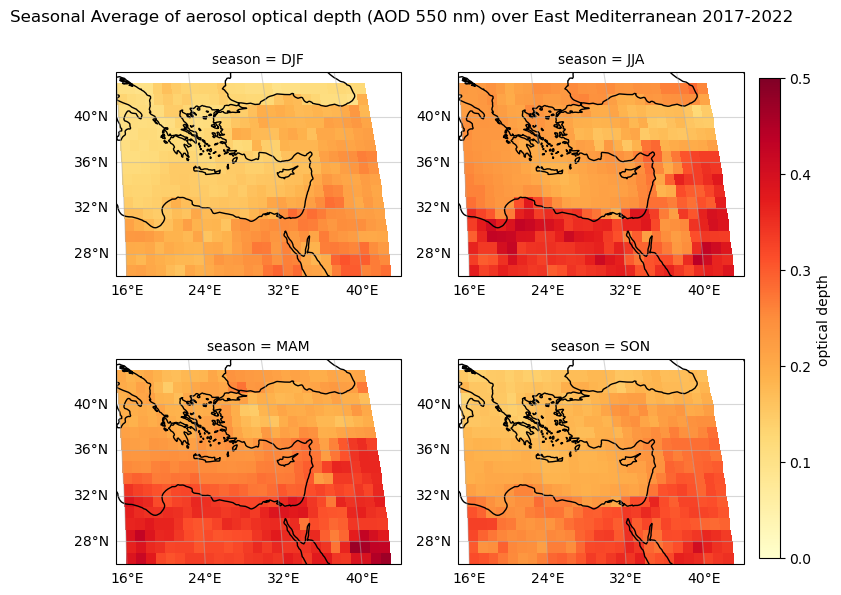

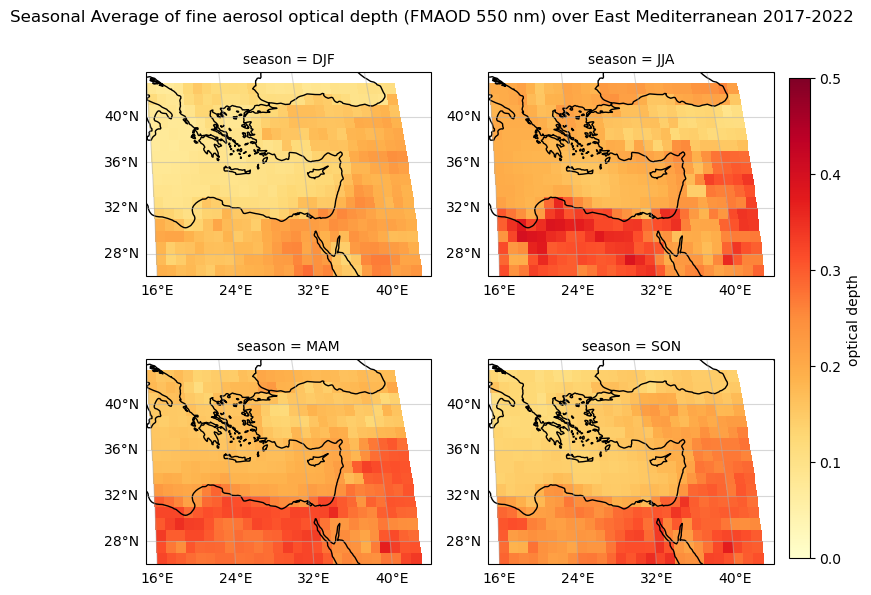

In [21]:
map_proj = ccrs.Robinson()

p = ds_seas_merged["AOD550"].plot.pcolormesh(cmap='YlOrRd', vmax=0.5, vmin=0, col="season", col_wrap=2,
                                    transform=ccrs.PlateCarree(),
                                    subplot_kws={"projection": map_proj},
                                    add_colorbar=False)

for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([16, 44, 26, 44], crs=ccrs.PlateCarree())


    gl = ax.gridlines(draw_labels=True, alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
  
    gl.xlocator = plt.MaxNLocator(5)
    gl.ylocator = plt.MaxNLocator(5)
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

mappable = p.axes[0][0].collections[0]

cax = plt.axes([1, 0.1, 0.03, 0.8])
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('optical depth ') 
plt.title(label="Seasonal Average of aerosol optical depth (AOD 550 nm) over East Mediterranean 2017-2022", x=-17, y=1.1)
plt.tight_layout()

plt.show()
###
map_proj = ccrs.Robinson()

p = ds_seas_merged["FM_AOD550"].plot.pcolormesh(cmap='YlOrRd', vmax=0.5, vmin=0, col="season", col_wrap=2,
                                    transform=ccrs.PlateCarree(),
                                    subplot_kws={"projection": map_proj},
                                    add_colorbar=False)

for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([16, 44, 26, 44], crs=ccrs.PlateCarree())


    gl = ax.gridlines(draw_labels=True, alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
     
    gl.xlocator = plt.MaxNLocator(5)
    gl.ylocator = plt.MaxNLocator(5)
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

mappable = p.axes[0][0].collections[0]

cax = plt.axes([1, 0.1, 0.03, 0.8])
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('optical depth ') 
plt.title(label="Seasonal Average of fine aerosol optical depth (FMAOD 550 nm) over East Mediterranean 2017-2022", x=-17, y=1.1)
plt.tight_layout()

plt.show()

##The figures show the presence of the megacities of Cairo, Istanbul, and Athens. In order to further investigate the AOD 550 nm concentration in Cairo and the surrounding area, we will plot on a monthly time aggregation the spatially weighted mean timeseries of AOD for these two areas. 

###Setting up the data request and downloading the monthly average dataset for the versionsv2.1 and v2.2 and define latitude and longitude for "Cairo" and "Tanta".

In [7]:
from c3s_eqc_automatic_quality_control import download

collection_id = "satellite-aerosol-properties"
request2 = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
}

time_dict = {
       "v2.1": {"start": "2018-11", "stop": "2020-06"},
       "v2.2": {"start": "2020-07", "stop": "2022-06"},
}
lon_slicecairo= slice(31.22, 32)
lat_slicecairo = slice(29, 30.3)

lon_slicetanta= slice(30.94, 31.5)
lat_slicetanta = slice(31, 32)


##Define functions to calculate the seasonal mean of AOD and FMAOD for the determined period.

In [8]:

def source_to_time_monthly(ds):
    # Naming convention: YYYYMM-*.nc
    ds["source"] = pd.to_datetime(ds["source"].str.slice(None, 6), format="%Y%m")
    return ds.rename(source="time")


def source_to_time_monthly_and_spatial_weighted_mean(ds):
    ds = ds.set_coords("source") 
    ds = utils.regionalise(ds, lon_slice=lon_slicecairo, lat_slice=lat_slicecairo)
    return diagnostics.spatial_weighted_mean(source_to_time_monthly(ds))

def source_to_time_monthly_and_spatial_weighted_mean1(ds):
    ds = ds.set_coords("source")  
    ds = utils.regionalise(ds, lon_slice=lon_slicetanta, lat_slice=lat_slicetanta)
    return diagnostics.spatial_weighted_mean(source_to_time_monthly(ds))




##Download the monthly and spatially weighted mean AOD and FMAOD for Cairo.

In [9]:


ds_dictcairo = {}
for version, kwargs in time_dict.items():
    requests2 = download.update_request_date(
        request2 | {"version": version}, **kwargs, stringify_dates=True
    )
    ds_dictcairo[version] = download.download_and_transform(
        collection_id, requests2, 
    transform_func=source_to_time_monthly_and_spatial_weighted_mean,
        split_all=True,
    )

final_dataset = xr.merge(list(ds_dictcairo.values()))



100%|██████████| 730/730 [00:37<00:00, 19.56it/s]


##Download the monthly and spatially weighted mean AOD and FMAOD for Tanta.

In [10]:

ds_dicttanta = {}
for version, kwargs in time_dict.items():
    requests2 = download.update_request_date(
        request2 | {"version": version}, **kwargs, stringify_dates=True
    )
    ds_dicttanta[version] = download.download_and_transform(
        collection_id, requests2, 
    transform_func=source_to_time_monthly_and_spatial_weighted_mean1,
    split_all=True,)
    

final_dataset2 = xr.merge(list(ds_dicttanta.values()))



100%|██████████| 730/730 [00:36<00:00, 19.82it/s]


 ###Visualize the results
 
 #Line plots for the spatial mean of AOD and FMAOD at 550 nm over Cairo and Tanta for the determined period.

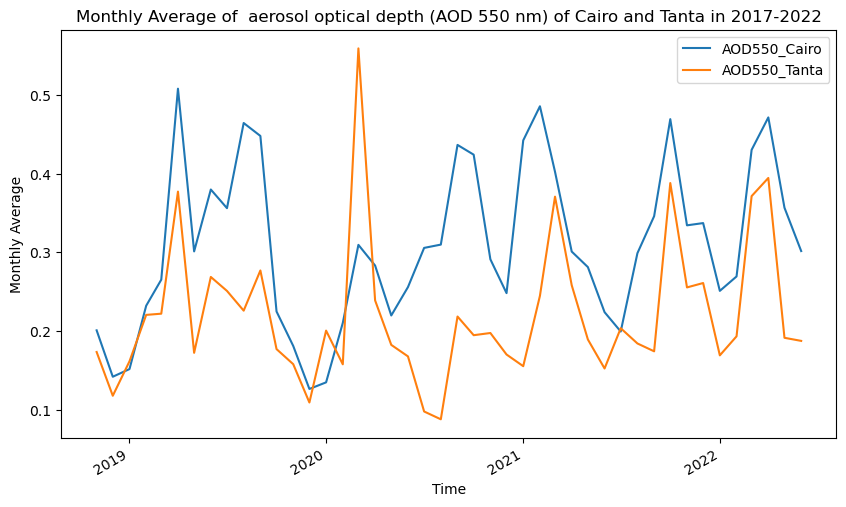

In [17]:
import matplotlib.pyplot as plt
import numpy as np
t = final_dataset["time"] 


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y1 = final_dataset['AOD550']
plt.plot(t, y1, label="AOD550_Cairo")

y2 = final_dataset2['AOD550']
plt.plot(t, y2, label="AOD550_Tanta")

ax.set_xlabel('Time')
ax.set_ylabel('Monthly Average')
ax.set_title('Monthly Average of  aerosol optical depth (AOD 550 nm) of Cairo and Tanta in 2017-2022')
ax.legend()

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(fontsize=10)

fig.autofmt_xdate()
plt.show()

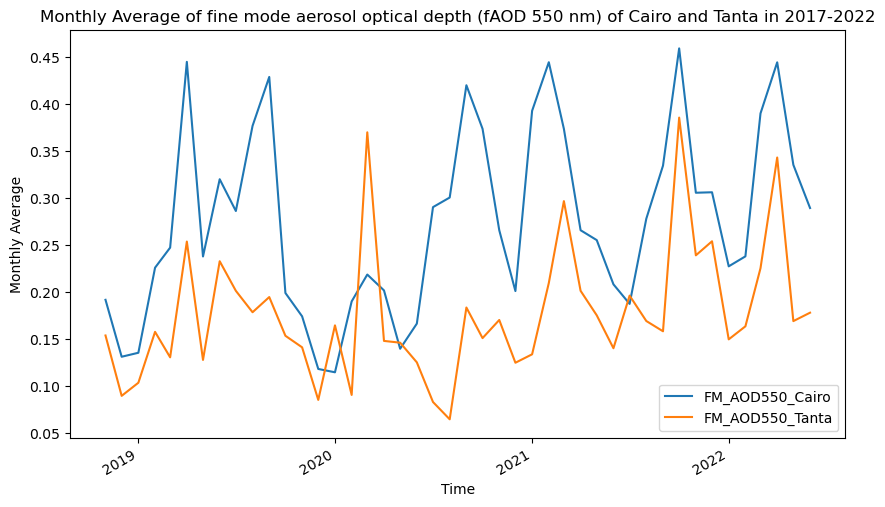

In [18]:
import matplotlib.pyplot as plt
import numpy as np
t = final_dataset["time"] 


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y1 = final_dataset['FM_AOD550']
plt.plot(t, y1, label="FM_AOD550_Cairo")

y2 = final_dataset2['FM_AOD550']
plt.plot(t, y2, label="FM_AOD550_Tanta")

ax.set_xlabel('Time')
ax.set_ylabel('Monthly Average')
ax.set_title('Monthly Average of fine mode aerosol optical depth (FMAOD 550 nm) of Cairo and Tanta in 2017-2022')
ax.legend()

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


plt.xticks(fontsize=10)

fig.autofmt_xdate()
plt.show()

###The figures show the spatially weighted mean timeseries of AOD and FMAOD at 550 nm and the related seasonal variability in the selected area. High seasonal mean values are displayed on the maps of the AOD and FMAOD for Cairo, in agreement with the condition of a megacity. The analysis of the SLSTR dataset also reveals that AOD in Cairo is larger than in Tanta, a nearby town out 94 km north of Cairo. The effect of the most relevant dust outbreaks occurs at the mesoscale; therefore, the presented results show the contrast between a town and a megacity, both affected by mineral dust, but with a higher pollution concentration in Cairo, as also outlined in the literature.

#References
1. Favez, O., Cachier, H., Sciare, J., Alfaro, S.C., El-Araby, T.M., Harhash, M.A. and Abdelwahab, M.M., 2008. Seasonality of major aerosol species and their transformations in Cairo megacity. Atmospheric Environment, 42(7), pp.1503-1516.
2. Flores, R.M., Özdemir, H., Ünal, A. and Tayanc, M., 2022. Distribution and sources of SVOCs in fine and coarse aerosols in the megacity of Istanbul. Atmospheric Research, 271, p.106100.
3. Kanakidou, M., Mihalopoulos, N., Kindap, T., Im, U., Vrekoussis, M., Gerasopoulos, E., Dermitzaki, E., Unal, A., Koçak, M., Markakis, K. and Melas, D., 2011. Megacities as hot spots of air pollution in the East Mediterranean. Atmospheric Environment, 45(6), pp.1223-1235.
4. Marey, H.S., Gille, J.C., El-Askary, H.M., Shalaby, E.A. and El-Raey, M.E., 2011. Aerosol climatology over Nile Delta based on MODIS, MISR and OMI satellite data. Atmospheric Chemistry and Physics, 11(20), pp.10637-10648.
5. Steiner, A.L., Tawfik, A.B., Shalaby, A., Zakey, A.S., Abdel-Wahab, M.M., Salah, Z., Solmon, F., Sillman, S. and Zaveri, R.A., 2014. Climatological simulations of ozone and atmospheric aerosols in the Greater Cairo region. Climate research, 59(3), pp.207-228.
6. Pappalardo, G., Wandinger, U., Mona, L., Hiebsch, A., Mattis, I., Amodeo, A., Ansmann, A., Seifert, P., Linné, H., Apituley, A. and Alados Arboledas, L., 2010. EARLINET correlative measurements for CALIPSO: First intercomparison results. Journal of Geophysical Research: Atmospheres, 115(D4).